**Read the data**

In [635]:
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.compose import ColumnTransformer

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/home-data-for-ml-course/sample_submission.csv
/kaggle/input/home-data-for-ml-course/train.csv.gz
/kaggle/input/home-data-for-ml-course/sample_submission.csv.gz
/kaggle/input/home-data-for-ml-course/test.csv.gz
/kaggle/input/home-data-for-ml-course/data_description.txt
/kaggle/input/home-data-for-ml-course/test.csv
/kaggle/input/home-data-for-ml-course/train.csv


In [636]:
home_data = pd.read_csv('/kaggle/input/home-data-for-ml-course/train.csv', index_col='Id')
X_test_full = pd.read_csv('/kaggle/input/home-data-for-ml-course/test.csv', index_col='Id')

**Numerical data**

In [637]:
numerical_features = home_data.select_dtypes(exclude=['object']).drop(['SalePrice'], axis=1).copy()

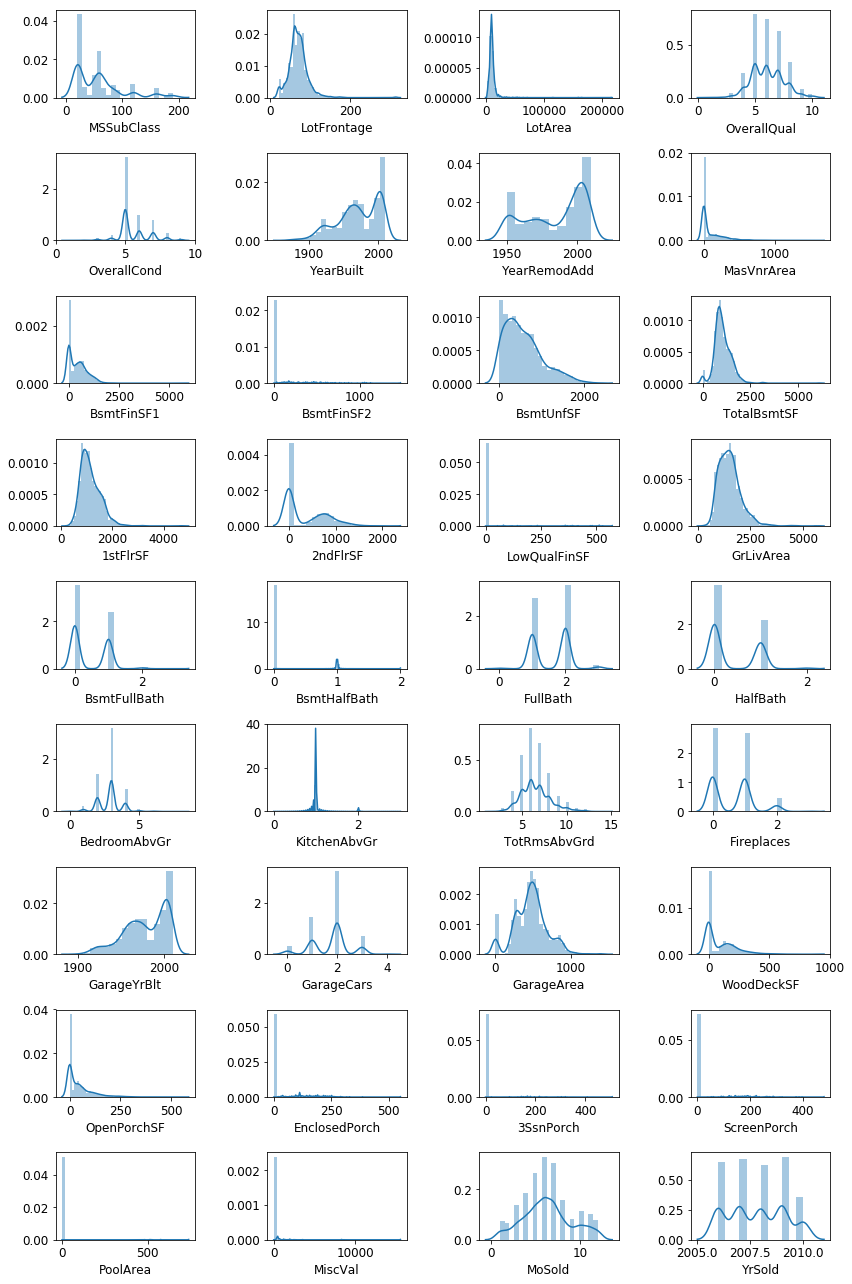

In [638]:
plt.rcParams.update({'font.size': 12})


fig = plt.figure(figsize=(12,18))
for i in range(len(numerical_features.columns)):
    fig.add_subplot(9,4,i+1)
    sns.distplot(numerical_features.iloc[:,i].dropna())
    plt.xlabel(numerical_features.columns[i])
plt.tight_layout()
plt.show()

**Look at potential correlation**

In [639]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=[30,15])
#Heatmap lookup
#https://towardsdatascience.com/feature-selection-with-pandas-e3690ad8504b
# One of the assumptions of linear regression is that the independent variables need to be uncorrelated with each other.
#If these variables are correlated with each other, then we need to keep only one of them and drop the rest.
sns.heatmap(home_data.corr(), annot=True)

<Figure size 2160x1080 with 0 Axes>

<Figure size 2160x1080 with 0 Axes>

Text(0.5, 1.0, 'Correlation wit Sale Price')

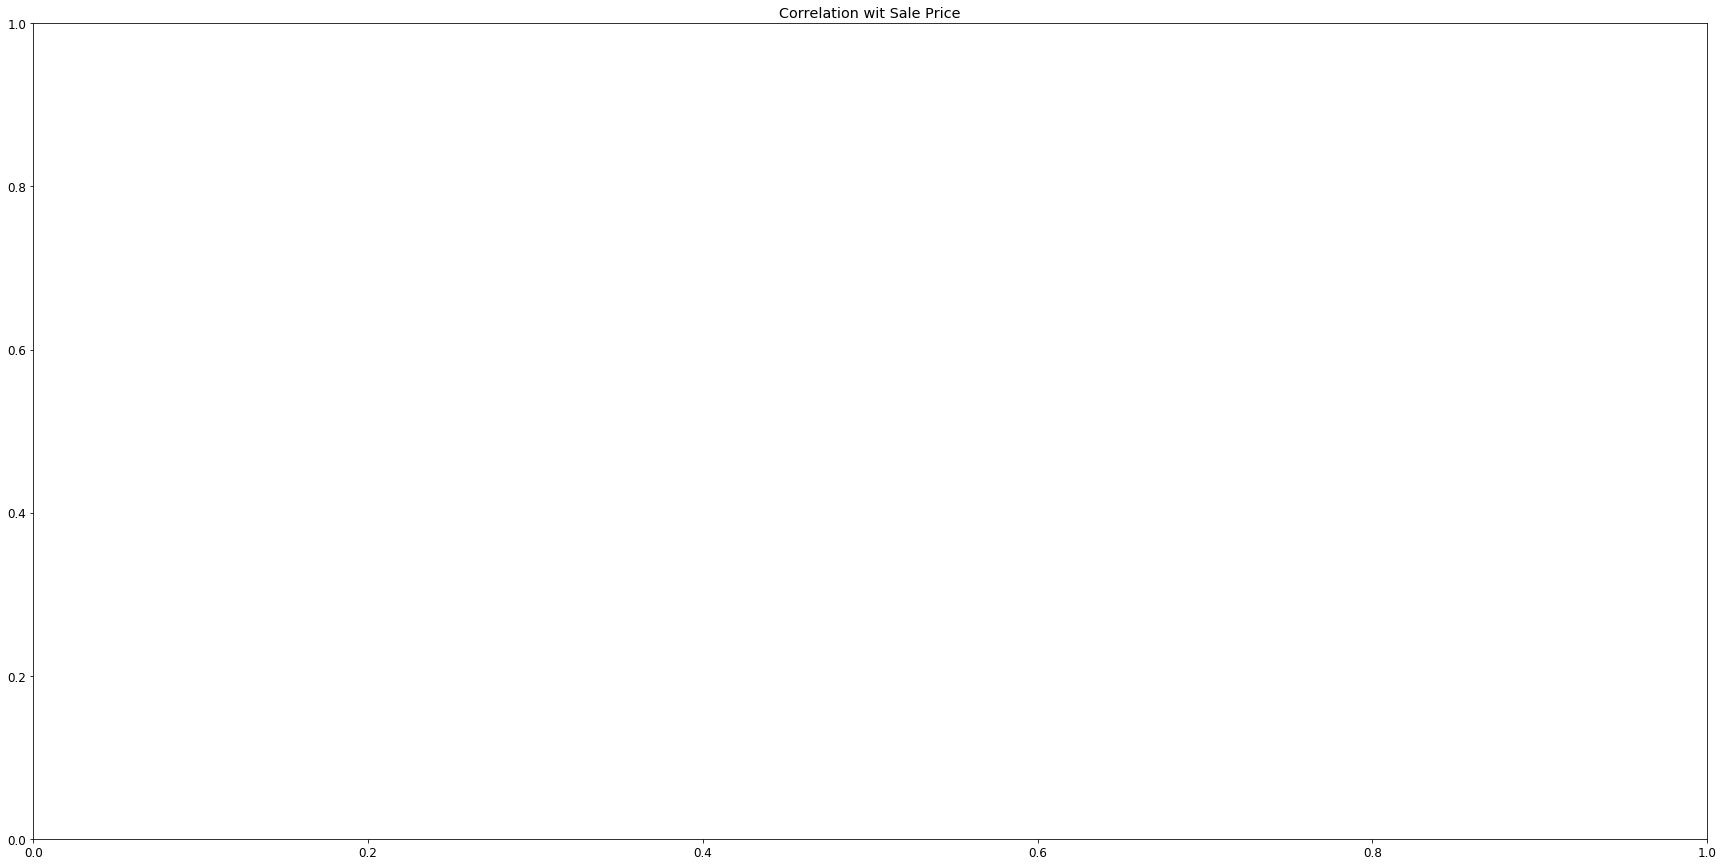

In [640]:
correlation_num = home_data.select_dtypes(exclude='object').corr()
plt.figure(figsize=(30,15))
plt.title('Correlation wit Sale Price')
sns.heatmap(data=correlation_num>0.80, annot=True)

**Categorical data**

In [641]:
home_data['MSSubClass'] = home_data['MSSubClass'].apply(str)
X_test_full['MSSubClass'] = X_test_full['MSSubClass'].apply(str)

home_data['MoSold'] = home_data['MoSold'].apply(str)
X_test_full['MoSold'] = X_test_full['MoSold'].apply(str)

**Add boolean flags (new features)**

In [642]:
def make_more_corr(tbl):
    tbl['TotalSF'] = tbl['TotalBsmtSF'] + tbl['1stFlrSF'] +tbl['2ndFlrSF']
    tbl['Total_Bathrooms'] = tbl['FullBath'] + (0.5* tbl['HalfBath']) + tbl['BsmtFullBath'] + (0.5* tbl['BsmtHalfBath'])
    tbl['Total_sqrt_footage'] = tbl['BsmtFinSF1'] +tbl['BsmtFinSF2'] + tbl['1stFlrSF']+tbl['2ndFlrSF']
    tbl['Total_porch_SF'] = tbl['OpenPorchSF'] + tbl['3SsnPorch'] +tbl['EnclosedPorch'] +  tbl['ScreenPorch'] + tbl['WoodDeckSF']

make_more_corr(home_data)
make_more_corr(X_test_full)

def remove_repeated_colls(tbl):
    repeated=['TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'FullBath', 'HalfBath',
             'BsmtFullBath', 'BsmtHalfBath', 'BsmtFinSF1', 'BsmtFinSF2', '1stFlrSF', '2ndFlrSF',
            'OpenPorchSF', '3SsnPorch', 'EnclosedPorch', 'ScreenPorch', 'WoodDeckSF']
    tbl.drop(repeated, axis=1, inplace=True)

**Add build year and garage year**

In [643]:
import datetime
now = datetime.datetime.now()

building_age = now.year - home_data['YearBuilt']
home_data['building_age'] = now.year - home_data['YearBuilt']
X_test_full['building_age'] = now.year - X_test_full['YearBuilt']

gar_age = now.year - home_data['GarageYrBlt']
home_data['garage_age'] = now.year - home_data['GarageYrBlt']
X_test_full['garage_age'] = now.year - X_test_full['GarageYrBlt']

In [644]:
def expand(tbl):
    tbl['haspool'] = tbl['PoolArea'].apply(lambda x:1 if x>0 else 0)
    tbl['has2ndFloor'] = tbl['2ndFlrSF'].apply(lambda x:1 if x>0 else 0)
    tbl['hasgarage'] = tbl['GarageArea'].apply(lambda x:1 if x>0 else 0)
    tbl['hasbsmt'] = tbl['TotalBsmtSF'].apply(lambda x:1 if x>0 else 0)
    tbl['hasfireplace'] = tbl['Fireplaces'].apply(lambda x:1 if x>0 else 0)
    
expand(home_data)
expand(X_test_full)

**Remove outliers**

In [645]:
home_data = home_data.drop(home_data['LotFrontage'][home_data['LotFrontage']>200].index)
home_data = home_data.drop(home_data['LotArea'][home_data['LotArea']>100000].index)
home_data = home_data.drop(home_data['BsmtFinSF1'][home_data['BsmtFinSF1']>4000].index)
home_data = home_data.drop(home_data['TotalBsmtSF'][home_data['TotalBsmtSF']>6000].index)
home_data = home_data.drop(home_data['1stFlrSF'][home_data['1stFlrSF']>4000].index)
home_data = home_data.drop(home_data.GrLivArea[(home_data['GrLivArea']>4000) & (home_data.SalePrice<300000)].index)
home_data = home_data.drop(home_data.LowQualFinSF[home_data['LowQualFinSF']>550].index)

**Drop repeated**

In [646]:
remove_repeated_colls(home_data)
remove_repeated_colls(X_test_full)

**Drop correlated data (from heatmap lookup)**

In [647]:
marked_cols = ['MiscVal', 'MSSubClass', 'MoSold', 'YrSold', 'GarageYrBlt'] 
home_data.drop(marked_cols, axis=1, inplace=True)
X_test_full.drop(marked_cols, axis=1, inplace=True)

In [648]:
X_full = home_data.copy()
X_full.dropna(axis=0, subset=['SalePrice'], inplace=True)
y = X_full.SalePrice
X_full.drop(['SalePrice'], axis=1, inplace=True)


In [649]:
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X_full, y, 
                                                                train_size=0.8, test_size=0.2,
                                                                random_state=0)

categorical_cols = [cname for cname in X_train_full.columns if
                    X_train_full[cname].nunique() < 10 and 
                    X_train_full[cname].dtype == "object"]

numerical_cols = [cname for cname in X_train_full.columns if 
                X_train_full[cname].dtype in ['int64', 'float64']]

my_cols = categorical_cols + numerical_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()
X_test = X_test_full[my_cols].copy()

In [650]:
# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='median')

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])


In [651]:
model = XGBRegressor(
    n_estimators=875,
    learning_rate=0.033,
    max_depth=3,
    colsample_bytree=0.4,
    colsample_bysplit=0.4,
    colsample_bylevel=0.5,
    subsample=0.7125,
    n_jobs=-1,
    random_state=0,
)

# Bundle preprocessing and modeling code in a pipeline
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('xgbmodel', model)
                     ])

clf.fit(X_train, y_train)

preds = clf.predict(X_valid)

print('MAE:', mean_absolute_error(y_valid, preds))

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:38:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE: 12766.146866945875


In [652]:
preds_test = clf.predict(X_test)

output = pd.DataFrame({'Id': X_test.index,
                       'SalePrice': preds_test})
output.to_csv('submission1.csv', index=False)